###1) Target:

Number of parameters in basic setup is extremely high. We need to reduce this. 

###2) Results:
Number of Parameters: 9380

Best Train Accuracy:98.59

Best Test Accuracy:98.67

###3) Analysis:
Model is lighter than basic setup.

Both Test and Train accuracy has gone down. But this is expected as we have reduced number of parameters drastically. 

Next we will further try to reduce number of parameters and see if we can maintain the same level of train and test accuracy

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


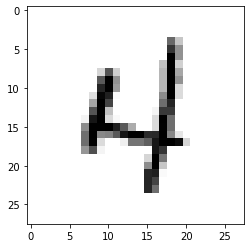

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

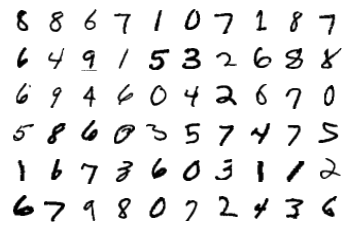

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):

      super().__init__()
      #Input Block
      self.input = nn.Sequential(nn.Conv2d(1,4,3, bias=False),
                                 nn.ReLU(inplace=True),
                                 ) # 4*26*26
      
      self.conv1 = nn.Sequential(nn.Conv2d(4, 8, 3, bias=False),
                                 nn.ReLU(inplace=True), #8*24*24
                                 nn.Conv2d(8, 16, 3, bias=False),
                                 nn.ReLU(inplace=True) #16*22*22
      )

      self.trans = nn.Sequential(nn.MaxPool2d(2,2), #16*11*11
                                 nn.Conv2d(16,8,1, bias=False),
                                 nn.ReLU(inplace=True) # 8*11*11
      )

      self.conv2 = nn.Sequential(nn.Conv2d(8, 8, 3, bias=False),
                                 nn.ReLU(inplace=True), #8*9*9
                                 nn.Conv2d(8, 16, 3, bias=False),
                                 nn.ReLU(inplace=True), #16*7*7
                                 nn.Conv2d(16, 16, 3, bias=False),
                                 nn.ReLU(inplace=True), #16*5*5
                                 nn.Conv2d(16, 16, 3, bias=False),
                                 nn.ReLU(inplace=True), #16*3*3
      )

      self.output = nn.Sequential(nn.Conv2d(16, 10, 3, bias=False)) #10*1*1


    def forward(self, x):
        x = self.input(x)
        x = self.conv1(x)
        x = self.trans(x)
        x = self.conv2(x)
        x = self.output(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
              ReLU-2            [-1, 4, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             288
              ReLU-4            [-1, 8, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           1,152
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8            [-1, 8, 11, 11]             128
              ReLU-9            [-1, 8, 11, 11]               0
           Conv2d-10              [-1, 8, 9, 9]             576
             ReLU-11              [-1, 8, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           1,152
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing
 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=4.302103042602539 Batch_id=468 Accuracy=12.34: 100%|██████████| 469/469 [00:10<00:00, 44.83it/s]



Test set: Average loss: 2.1419, Accuracy: 3063/10000 (30.63%)

EPOCH: 1


Loss=0.44459712505340576 Batch_id=468 Accuracy=39.76: 100%|██████████| 469/469 [00:10<00:00, 45.77it/s]



Test set: Average loss: 0.4872, Accuracy: 8467/10000 (84.67%)

EPOCH: 2


Loss=0.21744102239608765 Batch_id=468 Accuracy=91.38: 100%|██████████| 469/469 [00:10<00:00, 44.34it/s]



Test set: Average loss: 0.1579, Accuracy: 9490/10000 (94.90%)

EPOCH: 3


Loss=0.17096738517284393 Batch_id=468 Accuracy=95.65: 100%|██████████| 469/469 [00:10<00:00, 45.56it/s]



Test set: Average loss: 0.1182, Accuracy: 9642/10000 (96.42%)

EPOCH: 4


Loss=0.06187763810157776 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:10<00:00, 45.99it/s]



Test set: Average loss: 0.0922, Accuracy: 9728/10000 (97.28%)

EPOCH: 5


Loss=0.11154398322105408 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:10<00:00, 44.07it/s]



Test set: Average loss: 0.0717, Accuracy: 9786/10000 (97.86%)

EPOCH: 6


Loss=0.05060271546244621 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:10<00:00, 45.37it/s]



Test set: Average loss: 0.0728, Accuracy: 9766/10000 (97.66%)

EPOCH: 7


Loss=0.09132587164640427 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:10<00:00, 45.22it/s]



Test set: Average loss: 0.0547, Accuracy: 9833/10000 (98.33%)

EPOCH: 8


Loss=0.019717661663889885 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:10<00:00, 43.05it/s]



Test set: Average loss: 0.0527, Accuracy: 9841/10000 (98.41%)

EPOCH: 9


Loss=0.07402298599481583 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:10<00:00, 45.40it/s]



Test set: Average loss: 0.0490, Accuracy: 9850/10000 (98.50%)

EPOCH: 10


Loss=0.04264441132545471 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:10<00:00, 45.54it/s]



Test set: Average loss: 0.0548, Accuracy: 9831/10000 (98.31%)

EPOCH: 11


Loss=0.013982373289763927 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 44.84it/s]



Test set: Average loss: 0.0501, Accuracy: 9842/10000 (98.42%)

EPOCH: 12


Loss=0.01622549071907997 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:10<00:00, 45.09it/s]



Test set: Average loss: 0.0524, Accuracy: 9841/10000 (98.41%)

EPOCH: 13


Loss=0.15441475808620453 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:10<00:00, 45.33it/s]



Test set: Average loss: 0.0456, Accuracy: 9867/10000 (98.67%)

EPOCH: 14


Loss=0.0316302515566349 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:10<00:00, 45.29it/s]



Test set: Average loss: 0.0507, Accuracy: 9856/10000 (98.56%)



Text(0.5, 1.0, 'Test Accuracy')

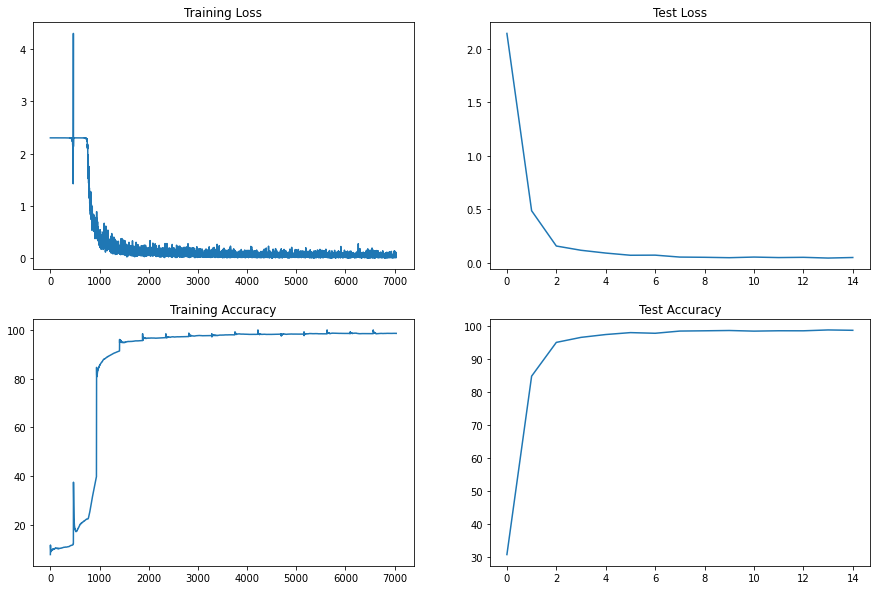

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")